Try to use CNN as an embedding net for inferring 3 params

In [8]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [7]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0, 0  # first set of odes
])



In [3]:
# 1x6000
#num_dim = 3
#num_timesteps = 1000
#prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
#batch_size = 1
#num_trajectories = 6

#def simulator(parameter_set):
    #initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    #t = np.linspace(0, 100, num_timesteps)
    #solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    #traj = torch.zeros((num_trajectories, num_timesteps))
    #for i in range(num_trajectories):
    #    for timestep in range(num_timesteps):
            #traj[i, timestep] = solution[timestep][i]
    #true_list = []
    #for tra in traj: #Erase this loop if we want 6x1000
     #   for timepoint in tra:
      #      true_list.append(timepoint)
    #true_tensor = torch.Tensor(true_list)
    #return true_tensor

#true_data = simulator(true_params)
#true_data

In [120]:
# 6x1000
num_dim = 3
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    
    return traj

true_data = simulator(true_params)
true_data.shape

torch.Size([6, 1000])

In [137]:
# 1000x6
num_dim = 3
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    true_list = []
    for tra in traj: #Erase this loop if we want 6x1000
        for timepoint in tra:
            true_list.append(timepoint)
    true_tensor = torch.Tensor(true_list)
    return true_tensor

true_data = simulator(true_params)
true_data

tensor([ 0.0000,  8.9123, 13.8703,  ...,  2.7314,  2.5905,  2.4615])

In [81]:
# set prior distribution for the parameters
num_dim = 3
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)



In [5]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sbi import utils
from sbi import analysis
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi


In [42]:
from sbi.neural_nets.embedding_nets import FCEmbedding, CNNEmbedding, PermutationInvariantEmbedding


embedding_net = CNNEmbedding(input_shape=(6, 1000))

/project/home23/sg2023/Desktop/SBI/.conda/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [135]:
#Define CNN ourselves
from typing import List, Optional, Tuple, Union
from sbi.neural_nets.embedding_nets import FCEmbedding
import torch
from torch import Tensor, nn

def get_new_cnn_output_size(
    input_shape: Tuple,
    conv_layer: Union[nn.Conv1d, nn.Conv2d],
    pool: Union[nn.MaxPool1d, nn.MaxPool2d],
) -> Union[Tuple[int], Tuple[int, int]]:
    """Returns new output size after applying a given convolution and pooling.

    Args:
        input_shape: tup.
        conv_layer: applied convolutional layers
        pool: applied pooling layer

    Returns:
        new output dimension of the cnn layer.

    """
    assert isinstance(input_shape, Tuple), "input shape must be Tuple."
    assert 0 < len(input_shape) < 3, "input shape must be 1 or 2d."
    assert isinstance(conv_layer.padding, Tuple), "conv layer attributes must be Tuple."
    assert isinstance(pool.padding, int), "pool layer attributes must be integers."

    out_after_conv = [
        calculate_filter_output_size(
            input_shape[i],
            conv_layer.padding[i],
            conv_layer.dilation[i],
            conv_layer.kernel_size[i],
            conv_layer.stride[i],
        )
        for i in range(len(input_shape))
    ]
    out_after_pool = [
        calculate_filter_output_size(
            out_after_conv[i],
            pool.padding,
            pool.dilation,
            pool.kernel_size,
            pool.stride,
        )
        for i in range(len(input_shape))
    ]
    return tuple(out_after_pool)

def calculate_filter_output_size(input_size, padding, dilation, kernel, stride) -> int:
    """Returns output size of a filter given filter arguments.

    Uses formulas from https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html.
    """

    return int(
        (int(input_size) + 2 * int(padding) - int(dilation) * (int(kernel) - 1) - 1)
        / int(stride)
        + 1
    )

class CNNEmbedding(nn.Module):
    def __init__(
        self,
        input_shape: Tuple,
        in_channels: int = 1,
        out_channels_per_layer: List = [6, 12],
        num_conv_layers: int = 2,
        num_linear_layers: int = 2,
        num_linear_units: int = 50,
        output_dim: int = 20,
        kernel_size: int = 4,
        pool_kernel_size: int = 2, #Change from 2???
    ):
        """Convolutional embedding network.
        First two layers are convolutional, followed by fully connected layers.

        Automatically infers whether to apply 1D or 2D convolution depending on
        input_shape.
        Allows usage of multiple (color) channels by passing in_channels > 1.

        Args:
            input_shape: Dimensionality of input, e.g., (28,) for 1D, (28, 28) for 2D.
            in_channels: Number of image channels, default 1.
            out_channels_per_layer: Number of out convolutional out_channels for each
                layer. Must match the number of layers passed below.
            num_cnn_layers: Number of convolutional layers.
            num_linear_layers: Number fully connected layer.
            num_linear_units: Number of hidden units in fully-connected layers.
            output_dim: Number of output units of the final layer.
            kernel_size: Kernel size for both convolutional layers.
            pool_size: pool size for MaxPool1d operation after the convolutional
                layers.
        """
        super(CNNEmbedding, self).__init__()

        assert isinstance(
            input_shape, Tuple
        ), "input_shape must be a Tuple of size 1 or 2, e.g., (width, [height])."
        assert (
            0 < len(input_shape) < 3
        ), """input_shape must be a Tuple of size 1 or 2, e.g.,
            (width, [height]). Number of input channels are passed separately"""

        use_2d_cnn = len(input_shape) == 2
        conv_module = nn.Conv2d if use_2d_cnn else nn.Conv1d
        pool_module = nn.MaxPool2d if use_2d_cnn else nn.MaxPool1d

        assert (
            len(out_channels_per_layer) == num_conv_layers
        ), "out_channels needs as many entries as num_cnn_layers."

        # define input shape with channel - 
        self.input_shape = (in_channels, *input_shape) #It just concatenates the in_channels with the width and height, so 1, 1000, 6

        # Construct CNN feature extractor.
        cnn_layers = []
        cnn_output_size = input_shape #Output size is the same as input shape! 1, 1000, 6
        stride = 1
        padding = 1
        for ii in range(num_conv_layers): #We have 2 conv layers
            # Defining another 2D convolution layer
            conv_layer = conv_module(
                in_channels=in_channels if ii == 0 else out_channels_per_layer[ii - 1],
                out_channels=out_channels_per_layer[ii],
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            )
            pool = pool_module(kernel_size=pool_kernel_size, stride=1)
            cnn_layers += [conv_layer, nn.ReLU(inplace=True), pool]
            # Calculate change of output size of each CNN layer
            cnn_output_size = get_new_cnn_output_size(cnn_output_size, conv_layer, pool)

        self.cnn_subnet = nn.Sequential(*cnn_layers)

        # Construct linear post processing net.
        self.linear_subnet = FCEmbedding(
            input_dim=out_channels_per_layer[-1]
            * torch.prod(torch.tensor(cnn_output_size)),
            output_dim=output_dim,
            num_layers=num_linear_layers,
            num_hiddens=num_linear_units,
        )

    # Defining the forward pass
    def forward(self, x: Tensor) -> Tensor:
        batch_size = x.size(0)

        # reshape to account for single channel data.
        x = self.cnn_subnet(x.view(batch_size, *self.input_shape))
        # flatten for linear layers.
        x = x.view(batch_size, -1)
        x = self.linear_subnet(x)
        return x
    
embedding_net = CNNEmbedding(input_shape=(1000, 6))

In [98]:
# Dirty code to check above
input_shape = (1000, 6)
use_2d_cnn = len(input_shape) == 2
conv_module = nn.Conv2d if use_2d_cnn else nn.Conv1d
pool_module = nn.MaxPool2d if use_2d_cnn else nn.MaxPool1d
in_channels = 1
out_channels_per_layer = [6, 12]
cnn_layers = []
len(input_shape)

2

In [100]:
#dirty
for ii in range(2): #We have 2 conv layers
            # Defining another 2D convolution layer
            conv_layer = conv_module(
                in_channels=in_channels if ii == 0 else out_channels_per_layer[ii - 1],
                out_channels=out_channels_per_layer[ii],
                kernel_size=4,
                stride=1,
                padding=1,
            )
            pool = pool_module(kernel_size=2)
            cnn_layers += [conv_layer, nn.ReLU(inplace=True), pool]
cnn_layers

[Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]

In [102]:
cnn_output_size = get_new_cnn_output_size((1000,6), conv_layer, pool)

In [131]:
#dirty
input_shape = (1000, 6)
use_2d_cnn = len(input_shape) == 2
conv_module = nn.Conv2d if use_2d_cnn else nn.Conv1d
pool_module = nn.MaxPool2d if use_2d_cnn else nn.MaxPool1d
in_channels = 1
out_channels_per_layer = [6, 12]
cnn_layers = []
cnn_output_size = (1000, 6)
for ii in range(2): #We have 2 conv layers
            # Defining another 2D convolution layer
            conv_layer = conv_module(
                in_channels=in_channels if ii == 0 else out_channels_per_layer[ii - 1],
                out_channels=out_channels_per_layer[ii],
                kernel_size=4,
                stride=1,
                padding=1,
            )
            pool = pool_module(kernel_size=2, stride=1)
            cnn_layers += [conv_layer, nn.ReLU(inplace=True), pool]
            # Calculate change of output size of each CNN layer
            cnn_output_size = get_new_cnn_output_size(cnn_output_size, conv_layer, pool)
cnn_output_size # aha!if we change the pooling operation we avoid getting 0s

(996, 2)

Add padding to pool layer or reduce pooling kernel size! Alternatively we could change the pooling to do adaptive pooling (no need for strides nor kernels)

In [134]:
cnn_layers

[Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False),
 Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)]

In [138]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [140]:
# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=100)

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

In [141]:
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 531 epochs.

RuntimeError: (RuntimeError('Given groups=1, weight of size [6, 1, 1, 1], expected input[1, 2, 1000, 6] to have 1 channels, but got 2 channels instead'), 'Debug hint: The simulated data x has 2 dimensions.\n            With default settings, sbi cannot deal with multidimensional simulations.\n            Make sure to use an embedding net that reduces the dimensionality, e.g., a\n            CNN in case of images, or change the simulator to return one-dimensional x.\n 

In [145]:
# 1000x6
num_dim = 3
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data #TRUE DATA

tensor([[  0.0000,   8.9123,  13.8703,  ...,  46.9959,  42.7398,  38.8630],
        [  1.0000,   1.3648,   2.3506,  ..., 113.7526, 107.1846, 100.8554],
        [  0.0000,  12.9051,  14.4150,  ...,  56.8882,  63.3755,  70.3635],
        [  3.0000,   3.4811,   4.4862,  ...,  25.9989,  29.2513,  32.8362],
        [  0.0000,  42.9083,  61.6269,  ...,   1.2610,   1.2439,   1.2295],
        [  2.0000,   4.0501,   8.8289,  ...,   2.7314,   2.5905,   2.4615]])

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

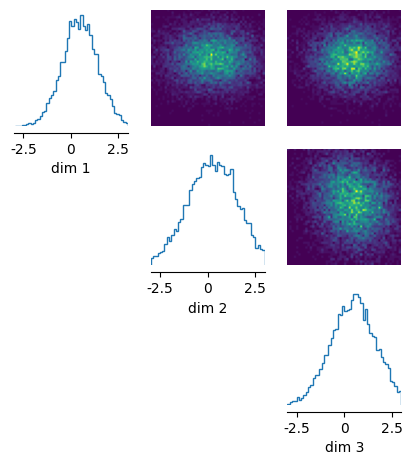

In [159]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3], [-3, 3]], figsize=(5, 5)
)